# Exercise 1
Rebuild , compile and train `model_1`, `model_2` and `model_5` using the `Keras Sequential API` instead of `Functional API`.

## Check the GPU

In [5]:
# Check for the GPU
!nvidia-smi

Sun Apr  2 09:26:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get the helper functions

In [6]:
# Download the helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback

--2023-04-02 09:26:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-02 09:26:36 (84.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

In [7]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2023-04-02 09:26:42--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.219.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-04-02 09:26:42 (133 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [8]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [9]:
# Shuffling the test dataset
train_data_shuffled = train_data.sample(frac=1, random_state=42)
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


### Split the data into training/validations sets

In [10]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_data_shuffled['text'],
                                                                            train_data_shuffled['target'],
                                                                            test_size=0.1,
                                                                            random_state=42)

In [11]:
# Check the lengths
len(train_sentences) == len(train_labels), len(val_sentences) == len(val_labels)

(True, True)

## Converting text data into numerical data

### Tokenization

In [12]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [13]:
# Setup the vectorization variables
max_vocab_length = 10000
max_length = 15

In [14]:
# Setup the TextVectorization 
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int', 
                                    output_sequence_length=max_length)

In [15]:
# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [16]:
# Create a sample set and vectorize it
sample_sentence = "We'd love the aliens to visit us!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1924,  110,    2, 6238,    5, 1742,   69,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [17]:
# Checking the vocabulary
vocab = text_vectorizer.get_vocabulary()
print(f"Top 5 most used words: {vocab[:5]}")
print(f"Top 5 least used words: {vocab[-5:]}")

Top 5 most used words: ['', '[UNK]', 'the', 'a', 'in']
Top 5 least used words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Embedding

In [18]:
from tensorflow.keras import layers

# Create embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # output shape
                             input_length=max_length) # input length

embedding

In [19]:
# Check if it works
print(f"Sample sentence: \n{sample_sentence}")
print(f"\nSample sentence vectorized: \n{text_vectorizer([sample_sentence])}")
print(f"\nSample sentence embedded: \n{embedding(text_vectorizer([sample_sentence]))}")

Sample sentence: 
We'd love the aliens to visit us!

Sample sentence vectorized: 
[[1924  110    2 6238    5 1742   69    0    0    0    0    0    0    0
     0]]

Sample sentence embedded: 
[[[ 0.03253646 -0.02474561  0.0096749  ... -0.01865226 -0.01686794
   -0.01096852]
  [ 0.01763327  0.04549273  0.02066935 ... -0.03454332 -0.02489433
   -0.02596654]
  [ 0.04962273  0.02548821 -0.0003642  ...  0.02688631  0.00779491
    0.04697153]
  ...
  [ 0.02340217 -0.02637414 -0.01749427 ...  0.0408749   0.02055774
   -0.01659428]
  [ 0.02340217 -0.02637414 -0.01749427 ...  0.0408749   0.02055774
   -0.01659428]
  [ 0.02340217 -0.02637414 -0.01749427 ...  0.0408749   0.02055774
   -0.01659428]]]


## Helper function to evaluate the models

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate precision, recall and f1-score (in 'weighted' mode)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true,
                                                             y_pred,
                                                             average='weighted')
  
  results = {'accuracy': accuracy,
             'precision': precision,
             'recall': recall,
             'f1-score': f1}

  return results

In [21]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

SAVE_DIR = 'exercise_model_logs'

## Model 1 reproduction - simple dense model





In [22]:
# Create the model with Sequential API
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
], name='model_1_dense')

model_1.summary()

# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Fit the model 
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'model_1_dense_Sequential')],
                              verbose=2)

Saving TensorBoard log files to: exercise_model_logs/model_1_dense_Sequential/20230402-092647
Epoch 1/5
215/215 - 22s - loss: 0.6117 - accuracy: 0.7037 - val_loss: 0.5400 - val_accuracy: 0.7428 - 22s/epoch - 103ms/step
Epoch 2/5
215/215 - 2s - loss: 0.4427 - accuracy: 0.8164 - val_loss: 0.4692 - val_accuracy: 0.7822 - 2s/epoch - 11ms/step
Epoch 3/5
215/215 - 3s - loss: 0.3476 - accuracy: 0.8634 - val_loss: 0.4571 - val_accuracy: 0.7927 - 3s/epoch - 15ms/step
Epoch 4/5
215/215 - 2s - loss: 0.2848 - accuracy: 0.8889 - val_loss: 0.4634 - val_accuracy: 0.7848 - 2s/epoch - 11ms/step
Epoch 5/5
215/215 - 1s - loss: 0.2384 - accuracy: 0.9120 - val_loss: 0.4812 - val_accuracy: 0.7848 - 1s/epoch - 5ms/step


In [24]:
# Function to evaluate and predict
def evaluate_and_pred(model, data_to_predict, labels_to_predict):
  """
  Evaluates on data_to_predict and returns predictions as 1 or 0.
  """

  # Evaluate the model
  eval = model.evaluate(data_to_predict, labels_to_predict)
  print(f"Evaluation metrics: {eval}\n")

  # Get the predictions 
  pred_probs = model.predict(data_to_predict)
  preds = tf.squeeze(tf.round(pred_probs))

  print(f"Preds overview: {preds[:10]}")

  return preds

In [25]:
# Evaluation and preds
model_1_preds = evaluate_and_pred(model_1, val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4812 - accuracy: 0.7848
Evaluation metrics: [0.48123079538345337, 0.7847769260406494]

24/24 [==============================] - 0s 2ms/step
Preds overview: [0. 1. 1. 0. 0. 1. 1. 1. 1. 0.]


In [26]:
# Calculate the results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results


{'accuracy': 0.7847769028871391,
 'precision': 0.789165199286798,
 'recall': 0.7847769028871391,
 'f1-score': 0.7818959205825942}

## Model 2 - LSTM

In [27]:
from tensorflow.keras import layers

# Create the model
model_2 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.LSTM(units=64),
    layers.Dense(1, activation='sigmoid')
], name='model_2_lstm')

# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Check the summary
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_lstm')],
                              verbose=2)

Saving TensorBoard log files to: exercise_model_logs/model_2_lstm/20230402-092730
Epoch 1/5
215/215 - 14s - loss: 0.2199 - accuracy: 0.9178 - val_loss: 0.5425 - val_accuracy: 0.7848 - 14s/epoch - 67ms/step
Epoch 2/5
215/215 - 4s - loss: 0.1545 - accuracy: 0.9439 - val_loss: 0.7553 - val_accuracy: 0.7808 - 4s/epoch - 19ms/step
Epoch 3/5
215/215 - 2s - loss: 0.1317 - accuracy: 0.9523 - val_loss: 0.6999 - val_accuracy: 0.7848 - 2s/epoch - 11ms/step
Epoch 4/5
215/215 - 2s - loss: 0.1034 - accuracy: 0.9603 - val_loss: 0.7878 - val_accuracy: 0.7756 - 2s/epoch - 8ms/step
Epoch 5/5
215/215 - 3s - loss: 0.0861 - accuracy: 0.9660 - val_loss: 1.0286 - val_accuracy: 0.7743 - 3s/epoch - 14ms/step


In [29]:
# Evaluate and predict
model_2_preds = evaluate_and_pred(model_2, val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 1.0286 - accuracy: 0.7743
Evaluation metrics: [1.0286036729812622, 0.7742782235145569]

24/24 [==============================] - 0s 3ms/step
Preds overview: [0. 1. 1. 0. 0. 1. 1. 1. 1. 0.]


In [30]:
# Calculate results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.7742782152230971,
 'precision': 0.7757380419380466,
 'recall': 0.7742782152230971,
 'f1-score': 0.7723566516531356}

## Model 5 - 1D Convolutional NN

In [31]:
# Create the model
model_5 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Conv1D(filters=64, 
                  kernel_size=5,
                  strides=1,
                  activation='relu',
                  padding='same'),
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation='sigmoid')
], name='model_5_conv1d')

# Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Check the summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,321,089
Trainable params: 1,321,089


In [32]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_conv1d')])

Saving TensorBoard log files to: exercise_model_logs/model_5_conv1d/20230402-092813
Epoch 1/5
215/215 [==============================] - 18s 54ms/step - loss: 0.1465 - accuracy: 0.9499 - val_loss: 0.7711 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0962 - accuracy: 0.9661 - val_loss: 0.8328 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0762 - accuracy: 0.9726 - val_loss: 0.9398 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0658 - accuracy: 0.9734 - val_loss: 0.9962 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0593 - accuracy: 0.9769 - val_loss: 1.0364 - val_accuracy: 0.7756


In [33]:
# Evaluate and predict
model_5_preds = evaluate_and_pred(model_5, val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 1.0364 - accuracy: 0.7756
Evaluation metrics: [1.0363507270812988, 0.7755905389785767]

24/24 [==============================] - 0s 2ms/step
Preds overview: [0. 1. 1. 0. 0. 1. 1. 1. 1. 1.]


In [34]:
# Calculate results
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.7755905511811023,
 'precision': 0.7753012250305231,
 'recall': 0.7755905511811023,
 'f1-score': 0.7749585155146131}

# Exercise 2
Retrain the baseline model with 10% of the training data. How does it perform to the Universal Sentence Encoder model with 10% of the training data?

In [35]:
# Getting the right amount of data for the split
train_10_percent_split = int(0.1 * len(train_sentences))

# Recreate the 10% training data split
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

# Check the split
print(f"Length of base set: {len(train_sentences)}")
print(f"Length of 10 percent set: {len(train_sentences_10_percent)}")

Length of base set: 6851
Length of 10 percent set: 685


In [36]:
# Recreating the baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline with tokenization
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to 10% dataset
model_0.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [37]:
# Evaluate and pred
model_0_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model score: {model_0_score}")

model_0_preds = model_0.predict(val_sentences)
model_0_preds[:10]

Baseline model score: 0.7020997375328084


array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [38]:
# Calculate results
model_0_results = calculate_results(val_labels, model_0_preds)
model_0_results

{'accuracy': 0.7020997375328084,
 'precision': 0.7599524002753854,
 'recall': 0.7020997375328084,
 'f1-score': 0.6736831571468213}

## Answer
How did the model perform compared to USE model from `08` notebook?
* The USE model trained on 10% of the data did get about 77,5%.
* The retrained baseline model from `sklearn` with `MultinomialNB` classifier, also trained on about 70,2% accuracy.

**This shows that the smaller the dataset, maybe using the pretrained model from TF Hub is a good idea to include in the experiment workflow.**


# Exercise 3
Try fine-tuning the TF Hub USE (`model_6`) by setting `training=True` when instentiating it as a Keras layer.

In [39]:
# Importing the USE 
import tensorflow_hub as hub
USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(USE_URL)

# Try out the USE
embed_sample = embed([sample_sentence])
print(embed_sample[0][:20])

tf.Tensor(
[ 0.00910181 -0.01275036 -0.02675992 -0.06155284  0.00590177 -0.06304008
 -0.04478858 -0.06164156 -0.04161551 -0.05248842  0.06968987  0.02778336
 -0.03118137  0.0318342  -0.01928731 -0.08036631  0.00304867 -0.05874978
 -0.02073361  0.0433057 ], shape=(20,), dtype=float32)


In [40]:
# Create a Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(handle=USE_URL,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE_fine_tuned')

In [41]:
# Create the model
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    #layers.Dense(32, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Summary
model_6.summary()

# Layer status
for layer in model_6.layers:
  print(layer.trainable, layer.name)

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_fine_tuned (KerasLayer)  (None, 512)              256797824 
                                                                 
 dense_3 (Dense)             (None, 32)                16416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 256,814,273
Trainable params: 16,449
Non-trainable params: 256,797,824
_________________________________________________________________
False USE_fine_tuned
True dense_3
True dropout
True output_layer


In [42]:
# Fit the model
tf.random.set_seed(42)

initial_epochs = 5

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=initial_epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_6_USE')]
                              )

Saving TensorBoard log files to: exercise_model_logs/model_6_USE/20230402-092904
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.5304 - accuracy: 0.7794 - val_loss: 0.4553 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4289 - accuracy: 0.8081 - val_loss: 0.4404 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4108 - accuracy: 0.8192 - val_loss: 0.4350 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4036 - accuracy: 0.8210 - val_loss: 0.4318 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3985 - accuracy: 0.8247 - val_loss: 0.4309 - val_accuracy: 0.8123


In [43]:
# Check the results
model_6_preds = evaluate_and_pred(model_6, val_sentences, val_labels)
model_6_results = calculate_results(val_labels, model_6_preds)

24/24 [==============================] - 0s 11ms/step - loss: 0.4309 - accuracy: 0.8123
Evaluation metrics: [0.43090760707855225, 0.8123359680175781]

24/24 [==============================] - 1s 10ms/step
Preds overview: [0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


In [44]:
for layer in model_6.layers:
  layer.trainable=True
  print(layer.name, layer.trainable)

USE_fine_tuned True
dense_3 True
dropout True
output_layer True


In [45]:
# Recompile the model for fine-tuning
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-5),
                metrics=['accuracy'])

In [46]:
# Create ModelCheckpoint to save the best model trained
from tensorflow.keras.callbacks import ModelCheckpoint

CKPT_SAVE_DIR = "/content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6"

model_checkpoint_callback = ModelCheckpoint(filepath=CKPT_SAVE_DIR,
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=True,
                                            save_freq='epoch')

In [47]:
# Fine-tune the model
tf.random.set_seed(42)

fine_tuning_epochs = 5
total_epochs = initial_epochs + fine_tuning_epochs

model_6_fine_tuned_history = model_6.fit(train_sentences,
                                         train_labels,
                                         epochs=total_epochs,
                                         initial_epoch=model_6_history.epoch[-1],
                                         validation_data=(val_sentences, val_labels),
                                         callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                                'model_6_USE_fine_tuned'),
                                                    model_checkpoint_callback]
                                         )

Saving TensorBoard log files to: exercise_model_logs/model_6_USE_fine_tuned/20230402-092924
Epoch 5/10
215/215 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8327
Epoch 5: val_loss improved from inf to 0.42555, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 209s 814ms/step - loss: 0.3864 - accuracy: 0.8327 - val_loss: 0.4256 - val_accuracy: 0.8215
Epoch 6/10
215/215 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8390
Epoch 6: val_loss improved from 0.42555 to 0.42331, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 89s 412ms/step - loss: 0.3768 - accuracy: 0.8390 - val_loss: 0.4233 - val_accuracy: 0.8215
Epoch 7/10
215/215 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8413
Epoch 7: val_loss improved from 0.42331 to 0.42194, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 77s 358ms/step - loss: 0.3673 - accuracy: 0.8413 - val_loss: 0.4219 - val_accuracy: 0.8268
Epoch 8/10
215/215 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8482
Epoch 8: val_loss improved from 0.42194 to 0.42077, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 77s 356ms/step - loss: 0.3603 - accuracy: 0.8482 - val_loss: 0.4208 - val_accuracy: 0.8241
Epoch 9/10
215/215 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8491
Epoch 9: val_loss did not improve from 0.42077
215/215 [==============================] - 35s 164ms/step - loss: 0.3524 - accuracy: 0.8491 - val_loss: 0.4213 - val_accuracy: 0.8189
Epoch 10/10
215/215 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.8514
Epoch 10: val_loss improved from 0.42077 to 0.41873, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 66s 308ms/step - loss: 0.3485 - accuracy: 0.8514 - val_loss: 0.4187 - val_accuracy: 0.8241


### Best model so far

{'accuracy': 0.8254593175853019,
 'precision': 0.8257387867002456,
 'recall': 0.8254593175853019,
 'f1-score': 0.8248354823684468}

In [48]:
#from helper_functions import compare_historys
#compare_historys(model_6_history, model_6_fine_tuned_history, initial_epochs)

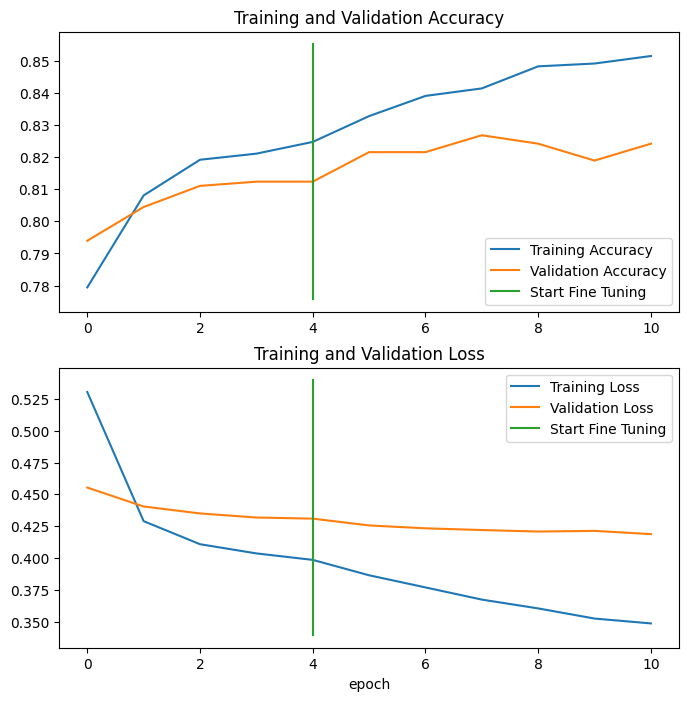

In [49]:
from helper_functions import compare_historys

compare_historys(model_6_history, model_6_fine_tuned_history, initial_epochs)

In [50]:
# Evaluate and pred
model_6_fine_tuning_preds = evaluate_and_pred(model_6, val_sentences, val_labels)
model_6_fine_tuning_preds[:10]

24/24 [==============================] - 1s 17ms/step - loss: 0.4187 - accuracy: 0.8241
Evaluation metrics: [0.4187305271625519, 0.8241469860076904]

24/24 [==============================] - 3s 48ms/step
Preds overview: [0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [51]:
# Calculate the results after fine tuning
model_6_fine_tuning_results = calculate_results(val_labels, model_6_fine_tuning_preds)
model_6_fine_tuning_results

{'accuracy': 0.8241469816272966,
 'precision': 0.8259136712963691,
 'recall': 0.8241469816272966,
 'f1-score': 0.8229273660088838}

In [52]:
# Compare the results
model_6_results

{'accuracy': 0.8123359580052494,
 'precision': 0.8145687227271431,
 'recall': 0.8123359580052494,
 'f1-score': 0.81078947666798}

In [53]:
# Saving directory
MODEL_SAVE_DIR = "/content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned"

In [54]:
# Save the model
#model_6.save(MODEL_SAVE_DIR)

In [ ]:
# Loading a model
loaded_model_6 = tf.keras.models.load_model(MODEL_SAVE_DIR)
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4177 - accuracy: 0.8255


[0.4176674485206604, 0.8254593014717102]

Looks that after a good chunk of experiments (slightly over 30) we've managed to get a model with `val_loss` under 0.42 which seemed a Holy Grail teritory at some point in time. However it was possible to do so and it's now saved, ready to be used again.

# Exercise 4
Retrain the best model you've got so far on the whole training set without the validation split. Then use this model to make predicions on the test dataset to use it on Kaggle Competition to see how you've performed.

In [ ]:
# Remind ourselves of the data
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
## Recreating the most successful training loop
tf.random.set_seed(42)

# TF Hub model - USE
import tensorflow_hub as hub
USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(USE_URL)

# Load USE into KerasLayer
sentence_encoder_layer = hub.KerasLayer(handle=USE_URL,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False, # USE layers frozen for feature extraction
                                        name='USE_fine_tuned')

# Create a base model_6 to fit on the data
model_final = tf.keras.Sequential([
    #layers.Input(shape=(1,), dtype=tf.string),
    sentence_encoder_layer,
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', name='output_layer'),
], name='model_USE_final')

# Compile
model_final.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Base fit
initial_epochs = 5

history_model_final = model_final.fit(train_data_shuffled['text'],
                                      train_data_shuffled['target'],
                                      epochs=initial_epochs,
                                      callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                             'model_final_USE')],
                                      )

# Unfreezing the USE layers for fine-tuning
for layer in model_final.layers:
  layer.trainable = True
  
# Recompiling the model for fine-tuning
model_final.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-5),
                    metrics=['accuracy'])

# Fine-tuning
fine_tuning_epochs = 5
total_epochs = initial_epochs + fine_tuning_epochs

history_model_final_fine_tuning = model_final.fit(train_data_shuffled['text'],
                                                  train_data_shuffled['target'],
                                                  epochs=total_epochs,
                                                  initial_epoch=history_model_final.epoch[-1],
                                                  callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                                         'model_final_USE_fine_tuned')]
                                                  )

Saving TensorBoard log files to: exercise_model_logs/model_final_USE/20230330-165744
Epoch 1/5
238/238 [==============================] - 6s 12ms/step - loss: 0.5340 - accuracy: 0.7745
Epoch 2/5
238/238 [==============================] - 4s 17ms/step - loss: 0.4337 - accuracy: 0.8091
Epoch 3/5
238/238 [==============================] - 3s 13ms/step - loss: 0.4158 - accuracy: 0.8157
Epoch 4/5
238/238 [==============================] - 3s 11ms/step - loss: 0.4063 - accuracy: 0.8229
Epoch 5/5
238/238 [==============================] - 3s 12ms/step - loss: 0.3985 - accuracy: 0.8249
Saving TensorBoard log files to: exercise_model_logs/model_final_USE_fine_tuned/20230330-165807
Epoch 5/10
238/238 [==============================] - 139s 464ms/step - loss: 0.3875 - accuracy: 0.8320
Epoch 6/10
238/238 [==============================] - 27s 112ms/step - loss: 0.3792 - accuracy: 0.8361
Epoch 7/10
238/238 [==============================] - 24s 101ms/step - loss: 0.3702 - accuracy: 0.8412
Epoch 8/1

In [ ]:
# Make predictions on test Kaggle dataset
test_df = pd.read_csv('test.csv')
test_df.head()

test_pred_probs = model_final.predict(test_df['text'].to_list())
test_preds = tf.squeeze(tf.round(test_pred_probs))
test_preds[:10]

102/102 [==============================] - 2s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = tf.cast(test_preds, dtype=tf.int64)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
submission.to_csv('submission_30032023.csv', index=False)

Kaggle results is 0.81642 which at the time of submission is rank 225 out of 1151 competitors.

# Exercise 5
Combine the ensemble predictions using the majority vote (mode). How does it perform in comparison to averaging the prediction probabiliteis of each model?

## The dumb way
Plain majority voting with already created predictions.

In [55]:
# Get the results from the earlier models
model_0_results, model_1_results, model_2_results, model_5_results, model_6_results

({'accuracy': 0.7020997375328084,
  'precision': 0.7599524002753854,
  'recall': 0.7020997375328084,
  'f1-score': 0.6736831571468213},
 {'accuracy': 0.7847769028871391,
  'precision': 0.789165199286798,
  'recall': 0.7847769028871391,
  'f1-score': 0.7818959205825942},
 {'accuracy': 0.7742782152230971,
  'precision': 0.7757380419380466,
  'recall': 0.7742782152230971,
  'f1-score': 0.7723566516531356},
 {'accuracy': 0.7755905511811023,
  'precision': 0.7753012250305231,
  'recall': 0.7755905511811023,
  'f1-score': 0.7749585155146131},
 {'accuracy': 0.8123359580052494,
  'precision': 0.8145687227271431,
  'recall': 0.8123359580052494,
  'f1-score': 0.81078947666798})

In [56]:
# Create a list of predictions for majority voting
preds = [model_0_preds, 
         model_1_preds, 
         model_2_preds, 
         model_5_preds, 
         model_6_preds]

preds = tf.cast(preds, dtype=tf.int32)
preds.shape
preds[:2][:10]

<tf.Tensor: shape=(2, 762), dtype=int32, numpy=
array([[1, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0]], dtype=int32)>

In [57]:
def majority_vote(model_preds):
  # Define empty list as an output
  results = []
  temp = 0

  uniform_0 = 0
  uniform_1 = 0

  # Get the shape of input
  model_no, pred_no = model_preds.shape
  
  # Majority voting loop
  for pred in range(pred_no):

    for model in range(model_no):
      temp = temp + model_preds[model][pred].numpy()
      
    results.append(temp/model_no)

    if temp == 0: uniform_0 += 1
    if temp == 1: uniform_1 += 1
    
    temp = 0

  total_uniform = uniform_0 + uniform_1
  print(f"All zeros: {uniform_0}")
  print(f"All ones: {uniform_1}")
  print(f"Total uniform votes: {total_uniform}, which equates to {total_uniform/pred_no*100:.2f}% ")

  return tf.round(results)

In [58]:
# Getting the ensemble predictions
ensemble_preds = majority_vote(preds)
ensemble_preds[:10], len(ensemble_preds) == len(model_0_preds)

All zeros: 346
All ones: 92
Total uniform votes: 438, which equates to 57.48% 


(<tf.Tensor: shape=(10,), dtype=float64, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.])>,
 True)

In [59]:
# Evaluating the ensemble predictions
ensemble_results = calculate_results(y_true=val_labels,
                                     y_pred=ensemble_preds)
ensemble_results

{'accuracy': 0.7965879265091863,
 'precision': 0.8016796937610012,
 'recall': 0.7965879265091863,
 'f1-score': 0.7937964447357466}

In [60]:
average_acc = model_0_results['accuracy'] + model_1_results['accuracy'] + model_2_results['accuracy'] + model_5_results['accuracy'] + model_6_results['accuracy']
print(average_acc/5)

0.7698162729658793


## The elegant way with a detour
Source: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

### The detour - an example of ensemble stacking NN models

**Multiclass classification problem**

In [ ]:
# Scatter plot of blobs dataset
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd

# Generate 2d classification dataset
X, y = make_blobs(n_samples=1000,
                  centers=3, 
                  n_features=2,
                  cluster_std=2,
                  random_state=2)

# Scatter plot, colored by class
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

colors = {0: 'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()

grouped = df.groupby('label')

for key, group in grouped:
  group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.show()

**Multilayer perceptron model**

In [ ]:
# Develop an MLP for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Generate 2D classification dataset
X,y = make_blobs(n_samples=1100,
                 centers=3,
                 n_features=2,
                 cluster_std=2,
                 random_state=2)

# One-hot encode output variables
y = to_categorical(y)

# Split into train and test sets
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

# Define the model
model = Sequential([
    Dense(32, input_dim=2, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# Fit the model
history = model.fit(trainX,
                    trainy,
                    epochs=500,
                    verbose=0,
                    validation_data=(testX, testy))

# Evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print(f"Train: {train_acc:.3f},\nTest: {test_acc:.3f}")

# Learning curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

**Train and save sub-models**

In [1]:
 # Example of saving sub-models for later use in a stacking ensemble
 from sklearn.datasets import make_blobs
 from tensorflow.keras.utils import to_categorical
 from tensorflow.keras.models import Sequential
 from tensorflow.keras.layers import Dense
 import matplotlib.pyplot as plt
 import os

 # Fitting the model on the dataset
 def fit_model(trainX, trainy):
   # Define the model
   model = Sequential([
       Dense(32, input_dim=2, activation='relu'),
       Dense(3, activation='softmax')
   ])
   model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
   
   # Fit the model
   model.fit(trainX, trainy, epochs=500, verbose=0)

   return model

# Generate 2D classification dataset
X, y = make_blobs(n_samples=1100, 
                  centers=3, 
                  n_features=2, 
                  cluster_std=2, 
                  random_state=2)

# One-hot encode the variables
y = to_categorical(y)

# Split into train and test datasets
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

# Create directory for models
try: os.makedirs('models')
except: print('Folder already created')
else: pass

# Fit and save models
n_members = 5

for i in range (n_members):

  # Fitting the model
  model = fit_model(trainX, trainy)
  
  # Saving the model
  filename = 'models/model_' + str(i + 1) + '.h5'
  model.save(filename)
  print(f"Saved {filename}")

(100, 2) (1000, 2)
Saved models/model_1.h5
Saved models/model_2.h5
Saved models/model_3.h5
Saved models/model_4.h5
Saved models/model_5.h5


**Separate stacking model**

In [8]:
# Stacked generalization with linear meta-model od blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load models from file
def load_all_models(n_models):
  all_models = list()

  for i in range(n_models):
    # Define filename for this ensemble
    filename = 'models/model_' + str(i+1) + '.h5'

    # Load model from file
    model = load_model(filename)

    # Add to the list of members
    all_models.append(model)
    print(f">Loaded {filename}")

  return all_models

# Create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
  stackX = None

  for model in members:

    # Make predictions
    yhat = model.predict(inputX, verbose=0)

    # Stack predictions into [rows, members, probabilities]
    if stackX is None: stackX = yhat
    else: stackX = np.dstack((stackX, yhat))

  # Flatten preditions to [rows, members x probabilities]
  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))

  return stackX

# Fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
  # Create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)

  # Fit standalone model (meta-learner)
  model = LogisticRegression()
  model.fit(stackedX, inputy)

  return model

# Make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
  # Create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)

  # Make a prediction
  yhat = model.predict(stackedX)

  return yhat

# Generate 2D classification dataset
X, y = make_blobs(n_samples=1100, 
                  centers=3, 
                  n_features=2,
                  cluster_std=2,
                  random_state=2)

# Train/test split
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

# Load all models
n_members = 5
members = load_all_models(n_members)
print(f"Loaded {n_members} models...")

# Evaluate standalone models on test dataset
for model in members:
  testy_enc = to_categorical(testy)
  _, acc = model.evaluate(testX, testy_enc, verbose=0)
  print(f"Model {model.name} accuracy: {acc:.4f}")

# Fit stacked model using ensemble
model = fit_stacked_model(members, testX, testy)

# Evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print(f"Stacked Test Accuracy: {acc:.4f}")

(100, 2) (1000, 2)
>Loaded models/model_1.h5
>Loaded models/model_2.h5
>Loaded models/model_3.h5
>Loaded models/model_4.h5
>Loaded models/model_5.h5
Loaded 5 models...
Model sequential accuracy: 0.8030
Model sequential_1 accuracy: 0.8150
Model sequential_2 accuracy: 0.8080
Model sequential_3 accuracy: 0.8080
Model sequential_4 accuracy: 0.8090
Stacked Test Accuracy: 0.8350
